# Machine Learning 4: Random Forrest for Binary Classification

## Submission by: Mark Preston

This week, I'll be using a data set focused on consumer credit default. The set includes various features around financial history and demographic information. The target variable is "default payment next month", which is just a binary flag of whether a customer defaults on a payment in the next month. 

### Data Processing

To start, I've loaded the initial data and highlighted the set dimensions.

In [3]:
import pandas as pd

pd.options.mode.chained_assignment = None

credit_default = pd.read_csv("credit_default_data.csv", low_memory=False)

print("The initial credit default data has", 
      credit_default.shape[0], "rows and", 
      credit_default.shape[1],  "columns")

The initial credit default data has 30000 rows and 24 columns


As always, it's essential to review the cleanliness of the data set. To this end, I've constructed the null counts for each column. Fortunately, this data set doesn't seem to have any major hygiene issues so it can be used as is since there are no null values to drop.

In [2]:
pd.DataFrame({"is_null_count": credit_default.isnull().sum()})

,is_null_count
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0
PAY_5,0


As a small cosmetic change, I've also renamed the outcome variable to "Default" given the initial label is long and somewhat clunky.

In [4]:
credit_default = credit_default.rename(index=str, columns={"default payment next month": "Default"})

With the cleaning complete, I've split the data into training and test for the modelling portion. I've elected to use a 70/30 split, which is confirmed by the dimensional prinout from the new sets.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

predictors = credit_default.drop(columns=["Default"], axis=1)

outcome = credit_default[["Default"]]

X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, random_state=1017, test_size=.3)

print(
"Training set rows:", X_train.shape[0], "which is", 
    np.round(X_train.shape[0] / credit_default.shape[0] * 100), 
    "percent of total records"
)

print(
"Test set rows:", X_test.shape[0], "which is", 
    np.round(X_test.shape[0] / credit_default.shape[0] * 100),
    "percent of total records"
)

Training set rows: 21000 which is 70.0 percent of total records
Test set rows: 9000 which is 30.0 percent of total records


### Random Forest Classifier: Developing a Baseline Model

Prior to developing the first random forrest, I wanted to check on the class balance for default in the set. Not surprsingly, the outcome here is imbalanced given defaults are generally less prevalent than individuals who meet their credit obligations. The ratio here is about 7:2, or about about 78% of customers here who have not defaulted in the test set. This means that 22% customers here have defaulted.

In [6]:
pd.DataFrame(y_test["Default"].value_counts())

,Default
0,6994
1,2006


Moving into the modelling work, I've set the random forest up below. It's a baseline configuration without any tuning. The only specification I've made here is including a random state, which acts as a seed so the result is reproducible. Given the random nature of the model, having this included helps ensure the predictions can be replicated again.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=1017)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1017, verbose=0,
            warm_start=False)

With the model fit, I've developed the default predictions below while including both class and probability values. Any probability values greater than .5 get classified as default. The first 5 rows from the classifier can be seen below.

In [9]:
baseline_rf_preds = pd.DataFrame({
    "actual": y_test["Default"],
    "class_pred": rf.predict(X_test),
    "no_default_prob": rf.predict_proba(X_test)[:,0],
    "default_prob": rf.predict_proba(X_test)[:,1]
})

baseline_rf_preds.head()

,actual,class_pred,default_prob,no_default_prob
21311,1,1,0.7,0.3
19046,0,0,0.0,1.0
18311,1,0,0.0,1.0
8868,0,0,0.2,0.8
23047,0,0,0.2,0.8


The initial confusion matrix shows good evaluation metrics overall but, the results could be enhanced given there is still a large number of Type I errors (i.e. false negatives). From a practical perspective, if a company was using this modelling approach, they would likely be interested in correctly classifying customers who default. Moreover, it would likely be preferable to have Type II errors (i.e. false positives) so the company could be cautionary about approaching customers who might default, even if they don't end up with the credit aberration. Fortunately, the model does show this pattern given there is a higher number of false positives as opposed to false negatives. 

In [10]:
from sklearn.metrics import confusion_matrix

default_cm = pd.DataFrame(confusion_matrix(y_true=y_test["Default"], 
                                           y_pred=baseline_rf_preds["class_pred"]), 
                          columns=pd.Series(["No Default", "Default"], dtype="category"),
                          index=pd.Series(["No Default", "Default"], dtype="category"))

default_cm

,No Default,Default
No Default,6586,408
Default,1370,636


The confusion matrix heat map reaffirms this. Ideally, I'd like to see the bottom right quadrant as a bright colour. However, this is not the case given the true negative and false negatives are reasonably close. While the model does well at classifying customers who do not default, it's the largest class so this isn't as helpful from a business utility perspective.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 7))

sns.heatmap(default_cm, 
            annot=True).set_title("Confusion matrix for credit default random forest: Classifier shows reasonable default predictions")

Text(0.5,1,'Confusion matrix for credit default random forest: Classifier shows reasonable default predictions')

Keeping with this thinking, the initial classification does provide some positive signs. For example, the .61 precision indicates the model has about a 61% success rate for classifying default cases. The .32 recall is troubling here but, I think precision is likely the metric to focus on given the application.

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test["Default"], baseline_rf_preds["class_pred"]))

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      6994
          1       0.61      0.32      0.42      2006

avg / total       0.78      0.80      0.78      9000



Further validating the model, the AUC score here isn't too bad. As a rule of thumb, a value over .7 would show the model has a decent trade-off between true and false positives. This is definitely a positive, given the model hasn't been tuned at all, but I think the recall still needs improvement.

In [12]:
import sklearn.metrics as metrics

print("Initial random forest default model AUC:", 
      metrics.roc_auc_score(y_test["Default"], baseline_rf_preds["default_prob"]).round(4))

Initial random forest default model AUC: 0.7285


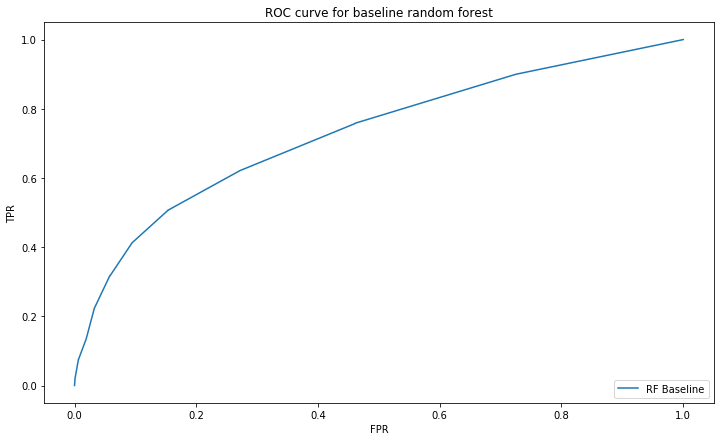

In [12]:
fpr, tpr, _ = metrics.roc_curve(y_test["Default"],  baseline_rf_preds["default_prob"])

plt.figure(figsize = (12, 7))

plt.plot(fpr,tpr,label = "RF Baseline")
plt.legend(loc = 4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for baseline random forest")
plt.show()

#### Calculate predictions for the training data & build the classification report & roc_auc_score. Are there signs of overfitting? Why or why not?

To evlauate how the model predictions shange from train to test, I've developed the training values below. The initial five rows, all of which are correct and have high default probabilities, suggest the model does very well on train.

In [13]:
baseline_rf_train_preds = pd.DataFrame({
    "actual": y_train["Default"],
    "class_pred": rf.predict(X_train),
    "no_default_prob": rf.predict_proba(X_train)[:,0],
    "default_prob": rf.predict_proba(X_train)[:,1]
})

baseline_rf_train_preds.head()

,actual,class_pred,default_prob,no_default_prob
2805,0,0,0.0,1.0
9536,1,1,0.6,0.4
15867,1,1,0.9,0.1
27579,1,1,0.8,0.2
19683,1,1,0.8,0.2


The confusion matrix confirms this.  The training accuracy is very high. However, this isn't a great sign given the test metrics showed cause for concern. The gulf between these results highlight a very high generalization error for the model, which is indicative of overfitting.

In [14]:
default_train_cm = pd.DataFrame(confusion_matrix(y_true=y_train["Default"], 
                                                 y_pred=baseline_rf_train_preds["class_pred"]),
                                columns=pd.Series(["No Default", "Default"], dtype="category"),
                                index=pd.Series(["No Default", "Default"], dtype="category"))

default_train_cm

,No Default,Default
No Default,16343,27
Default,414,4216


The evaluation report further bolsters this thinking. For example, the training recall is .91 while the test metric is .32. This is a huge drop off from train to test indicating the model is fitting the training data too closely and therefore, does not generalize well to new data. This is kind of deviation is typical of overfitting. 

In [15]:
print(classification_report(y_train["Default"], baseline_rf_train_preds["class_pred"]))
print("Initial random forest default model training AUC:", 
      metrics.roc_auc_score(y_train["Default"], baseline_rf_train_preds["default_prob"]).round(4))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     16370
          1       0.99      0.91      0.95      4630

avg / total       0.98      0.98      0.98     21000

Initial random forest default model training AUC: 0.999


### Random Forest Classifier: Grid Search Approach

The initial baseline random forest showed some promise but, ultimately is very over fit. However, this model was constructed without any tuning. A random forest has numerous hyperparameters that can be used to refine a given model. Looking at combinations of these manually is one possibility but, given the large number of parameters and their combinations, a more automated approach is preferable. Grid Search is this automated process, which will be used as the approach for constructing the next model.

To this end, I've developed a function that can produce all the necessary assignments requirements including, confusion matrices, classification reports, and AUC metrics for train and test. The idea here is to pass the function a new set of tuning parameters and the requisite objects will be returned. The first try at this is found below using the provided parameters. Using this approach, the best parameters are a max depth of 10, max features of 4, and n estimators of 500.

In [13]:
from sklearn.model_selection import GridSearchCV

tune_rf=RandomForestClassifier()

def custom_grid_rf(tune_params):
    #creating and tuning rf
    grid_search_rf = GridSearchCV(tune_rf, tune_params, cv = 5, scoring = "roc_auc", refit = True, n_jobs = -1, verbose = 5)
    grid_search_rf.fit(X_train, y_train.values.ravel())
    
    #developing predictions using model fit
    grid_search_train_preds = pd.DataFrame({
    "actual": y_train["Default"],
    "class_pred": grid_search_rf.best_estimator_.predict(X_train),
    "no_default_prob": grid_search_rf.best_estimator_.predict_proba(X_train)[:,0],
    "default_prob": grid_search_rf.best_estimator_.predict_proba(X_train)[:,1]
    })
    
    grid_search_test_preds = pd.DataFrame({
    "actual": y_test["Default"],
    "class_pred": grid_search_rf.predict(X_test),
    "no_default_prob": grid_search_rf.best_estimator_.predict_proba(X_test)[:,0],
    "default_prob": grid_search_rf.best_estimator_.predict_proba(X_test)[:,1]
    })
    
    #creating confusion matrix for preds
    default_tuned_train_cm = pd.DataFrame(confusion_matrix(y_true=y_train["Default"], 
                                                           y_pred=grid_search_train_preds["class_pred"]), 
                                          columns=pd.Series(["No Default", "Default"], dtype="category"),
                                          index=pd.Series(["No Default", "Default"], dtype="category"))
    
    default_tuned_test_cm = pd.DataFrame(confusion_matrix(y_true=y_test["Default"], 
                                                          y_pred=grid_search_test_preds["class_pred"]), 
                                          columns=pd.Series(["No Default", "Default"], dtype="category"),
                                          index=pd.Series(["No Default", "Default"], dtype="category"))
    
    #creating classification reports
    train_class_report = classification_report(y_train["Default"], 
                                               grid_search_train_preds["class_pred"])
    test_class_report = classification_report(y_test["Default"], 
                                              grid_search_test_preds["class_pred"])
    
    #creating auc
    train_auc = metrics.roc_auc_score(y_train["Default"], grid_search_train_preds["default_prob"]).round(4)
    test_auc = metrics.roc_auc_score(y_test["Default"], grid_search_test_preds["default_prob"]).round(4)
    
    #creating feature importance
    feature_importance = grid_search_rf.best_estimator_.feature_importances_
    
    output = {"test_cm": default_tuned_test_cm,
              "train_cm": default_tuned_train_cm,
              "test_report": test_class_report,
              "train_report": train_class_report,
              "test_auc": test_auc,
              "train_auc": train_auc,
              "feature_importance": feature_importance
              }
    
    print("Best model parameters from Grid Search:")
    print(grid_search_rf.best_params_)
    
    
    return(output)

grid_parameters = {
    "max_depth": [6, 8, 10, 12],
    "n_estimators": [50, 100, 500],
    "max_features": [2, 4, 6],
    "random_state":[1017]
}
    
tuned_rf = custom_grid_rf(tune_params= grid_parameters)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.9min finished


Best model parameters from Grid Search:
{'max_depth': 10, 'max_features': 4, 'n_estimators': 500, 'random_state': 1017}


The initial confusion matrix shows a nice upgrade from the baseline model, espeically with respect to true negative predictions.

In [22]:
tuned_rf["test_cm"]

,No Default,Default
No Default,6639,355
Default,1287,719


Furthering this conclusion, the test report shows an increase across all the average metrics by about 2 points. More specifically for this problem, I think the 6 point increase in precision is the most interesting upgrade. This means that the company using the model is finding 6% credit defaults using this method, which could be a substantial business boost.

In [23]:
print(tuned_rf["test_report"])

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      6994
          1       0.67      0.36      0.47      2006

avg / total       0.80      0.82      0.80      9000



In the same vein as the other evaluation metrics, the AUC using a more tuned model shows an increase. The baseline model had an AUC of .7285 so the tuned model has almost a 6 point increase. 

In [24]:
print("Tuned random forest model test AUC:", tuned_rf["test_auc"])

Tuned random forest model test AUC: 0.7856


One of the interesting questions here is how the train and test compare. The baseline model was very overfit, which manifested itself as a large divergence between train and test evaluation metrics. The train confusion matrix here shows a much more reasonable balance as opposed to baseline model. I think this implies the overfitting has been eased slightly.

In [25]:
tuned_rf["train_cm"]

,No Default,Default
No Default,15959,411
Default,2552,2078


The report confirms this, which shows the metrics are much more aligned. There may be some overfitting, as the train and test are not perfectly aligned, but the values are much closer. For example, the precision goes from .83 to .67, which though not ideal, is still a great improvement from the baseline model. Additionally, the AUC values are more congruent, though still show some gap.

In [28]:
print(tuned_rf["train_report"])

             precision    recall  f1-score   support

          0       0.86      0.97      0.92     16370
          1       0.83      0.45      0.58      4630

avg / total       0.86      0.86      0.84     21000



In [29]:
print("Tuned random forest model train AUC:", tuned_rf["train_auc"])

Tuned random forest model train AUC: 0.859


Given there were some signs of overfitting, I wanted to try a second tuned model with different parameters. I selected them using the initial parameter estimations so there might be a difference between the models. With this in mind, the parameters for max depth and minimum sample split are in the new selection but, with higher values after these. The assortment can be seen below. Th downside to adding further tuning options, for number of estimators as an example, is the training time increases drastically. The initial tuning took about 30 seconds while this variant was over an hour. The final model parameters from this are printed below.

In [44]:
grid_parameters_expanded = {
    "bootstrap": [True, False],
    "max_depth": [8, 10, 12],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [7, 8, 9],
    "n_estimators": [100, 200, 300],
    "random_state":[1017]
}

expanded_tuned_rf = custom_grid_rf(tune_params= grid_parameters_expanded)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 67.9min finished


Best model parameters from Grid Search:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 300, 'random_state': 1017}


Unfortunately, the confusion matrix does not seem improved. The classification report is fairly similar but, the F1 score average is slightly decreased. The AUC is also identical.

In [45]:
expanded_tuned_rf["test_cm"]

,No Default,Default
No Default,6638,356
Default,1292,714


In [49]:
print(expanded_tuned_rf["test_report"])

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      6994
          1       0.67      0.36      0.46      2006

avg / total       0.80      0.82      0.79      9000



In [48]:
print("Further tuned random forest model test AUC:", expanded_tuned_rf["test_auc"])

Tuned random forest model test AUC: 0.7865


The training metrics below also quite similar. Given the added computational time and an almost identical fit, I think the initial tuning option produces a more suitable model here.

In [54]:
expanded_tuned_rf["train_cm"]

,No Default,Default
No Default,15880,490
Default,2642,1988


In [53]:
print(expanded_tuned_rf["train_report"])

             precision    recall  f1-score   support

          0       0.86      0.97      0.91     16370
          1       0.80      0.43      0.56      4630

avg / total       0.85      0.85      0.83     21000



In [51]:
print("Tuned random forest model test AUC:", expanded_tuned_rf["train_auc"])

Tuned random forest model test AUC: 0.852


### Create a feature importance plot for your best performing model. What are the top 5 features for this model?

I've included a variable importance plot from the preferred random forest model below. The values are derived using Gini importance or mean decrease impurity across all the tree splits, which I'll explain in more depth in the next section. Using it as an importance metric, it appears that Pay 0 is the most important variable. The top 5 are also printed out below; these show payment related variables as the most important to the model. Without a formal dictionary, their exact meaning is unknown so it's hard to vet the result too much but, they might be some payment scheduling. Additionally, it appears the sum of money being paid is important, which seems intuitive.

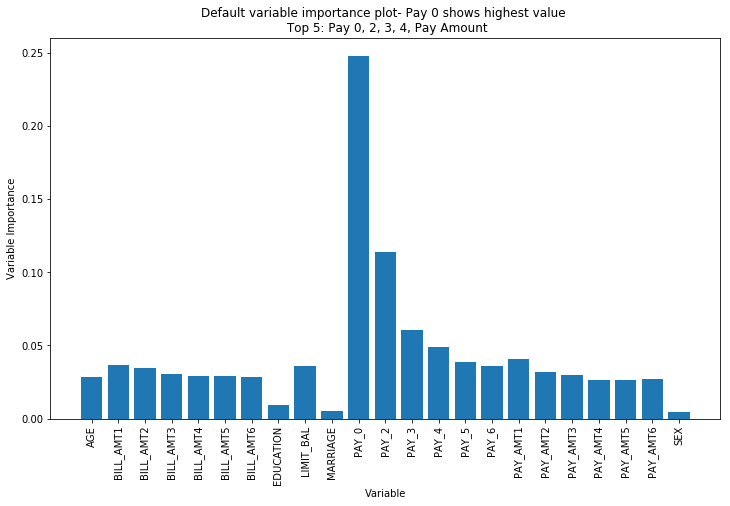

,name,var_importance
5,PAY_0,0.247940
6,PAY_2,0.114200
7,PAY_3,0.060460
8,PAY_4,0.048880
17,PAY_AMT1,0.040967


In [31]:
tuned_rf_importance = pd.DataFrame({
    "name": list(predictors.head(0)),
    "var_importance": tuned_rf["feature_importance"]
})

plt.figure(figsize = (12, 7))

plt.bar(tuned_rf_importance["name"], tuned_rf_importance["var_importance"],)
plt.xlabel("Variable")
plt.xticks(rotation=90)
plt.ylabel("Variable Importance")
plt.title("Default variable importance plot- Pay 0 shows highest value \n Top 5: Pay 0, 2, 3, 4, Pay Amount")
plt.show()

tuned_rf_importance.sort_values(by=["var_importance"], ascending=False).head()

### Conceptual Questions

#### What are the best parameters from the Grid Search in Question # 3? Does the Model from 3 outperform Model 2? Explain why.

I included the best parameters from the initial model development but, have included them here again for convenience:

Best model parameters from Grid Search:
{'max_depth': 10, 'max_features': 4, 'n_estimators': 500, 'random_state': 1017}

The tuned model outperformed the baseline model by a fair margin. The overall accuracy metrics improved, including precision, while the AUC also showed improvements. Further, the noticeable overfitting was reduced as seen by a narrowing between the training and test set accuracy metrics. 

The parameter tuning the biggest reason why this improvement can be found. Random Forest's are a very flexible model class and make no assumptions about the data. While this flexibility generally helps, it can lead to overfitting as the model adapts too closely to the training data. This was evident in the first model which had 99% accuracy on the training set, a metric that is too good to be true in most cases. Thereafter, there was a big decrease in test evaluation metrics. However, when the tree growth was capped (using max depth = 10), the model growth is regularized. In this sense, the model is constrained and cannot overfit as easily because the shape is governed more tightly. This is just one example of how hyperparameter tuning increases accuracy, which ultimately leads to the differences between the baseline model (2) and the updated model (3). 

#### Overfitting is always a concern in ML problems. Does Model  3 overfit data more or less than Model 2? Explain why you think this is the case. 

I mentioned this in the previous section but the baseline model showed far more overfitting. This is evaluated on the difference between the training and test evaluation metrics, which when showing a large gap, signal overfitting. The overfitting is from the random forest fitting the training data too closely. The baseline, default setting has no cap on tree growth, governed by max depth, so it ends up providing a model that is almost perfectly fit to the training data (hence the 99% accuracy). When that growth is capped, the model is much less overfit, though there was still some delta between train and test with the tuned model. 

#### The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?).

The Gini index is the main metric used to develop the tree splits in a random forest. In a set with numerous variables, there needs to be a method for picking which node could be split. At each node, the model could be split by different variables, which is where the index comes in. The algorithm searches for the split that provides the lowest Gini index value, which signals a more pure split (stemming from entropy and information studies). The next resulting split will have categorization based on the split, which can then be reassessed. With this in mind, it's the main metric that guides the tree development process. The final numbers from each split can then be used to assess variable importance once they have been summed and averaged.

#### Describe how Random Forest is different from bagging & why this difference can yield improved results

Bagging, or bootstrap aggregation, takes random with replacement samples from a data set and develops models on them. During this process every feature is considered, which in the case of the default models means all 23 predictors being included. By contrast, a random forest works on a randomized subset of features and rows. From this selection, the best feature is used to split the resulting trees. In the tuned model developed here, this is further capped by setting the max features to a specific value (4 in the final mode). Additionally, the appropriate number of randomized features can be selected using the out of bag error, which inherently means that an approximation of test error is being built into the model construction. With, this can yield better accuracy results.

#### Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance trade off might be impacted by the max_depth parameter.

I've alluded to this hyperparameter already and described how it affects tree growth but, I'll reemphasize here as well. Using the baseline model as an example, without any max depth set the trees can grow unconstrained. This yields a model that is almost perfectly fit for the training data. The issue with this is that is leads to very low training bias but, very high variance because the model doesn't generalize well to new, unseen samples. By constraining the model growth with max depth, the tree can only grow to a certain size thereby limiting its ability to mirror the training data too closely. As a result, the generalization error is also reduced. In this way, max depth directly helps govern the bias-variance trade off by ensuring the training model cannot fit the initial data too closely.

#### In this homework we used k-fold cross-validation while determining the optimal hyperparameters for our Random Forest model. Describe how k-fold cross-validation works.  What benefit do we gain by using k-fold cross-validation when tuning our Random Forest model versus only using the train-test split approach?

K-fold cross validation refers to dividing the project data into k different groups, five in the modelling work here, which are comprised of different sections from the initial set. With five folds, the set is broken into four sections for training and one section for testing. For example, one iterations might be 1, 2, 3, 4, with 5 as a test and then 1, 2, 3, 5, and 4 with the test. This is repeated for each fold permutation (5 times total). Using these five folds, an evaluation metric is derived and averaged. However, given the nature of random forests, a lot of this construction is inherently included in the method. As such, the main benefit when using it with the random forest model is tuning the hyperparameters for the second model. Using CV here enhances the approach to selecting these hyperparameters and evaluating which combinations and specifications perform best. For example, when the grid search is being conducted, the message indicates: "Fitting 5 folds for each of 36 candidates, totalling 180 fits". These added permutations helps narrow down the best hyperparameter combinations. As such, it is a worthwhile addition. 

In [20]:
import os
os.getcwd()

'C:\\Users\\Mark\\Machine Learning 4'